# Identifying objects in images.
## 1st dataset to try: CIFAR 10

Starting lines and imports

In [1]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

%load_ext autoreload
%autoreload 2

In [2]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print("CUDA is not available. Using CPU.")
else:
    print("CUDA is available. Using GPU.")

CUDA is not available. Using CPU.


## Load CIFAR 10

#### Define transforms for the dataset and load

In [3]:
transform_tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616))])
transform_tst = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4942, 0.4851, 0.4504),(0.2467, 0.2429, 0.2616))])

In [4]:
# CIFAR-10 training dataset and data loader
train_batch_size = 256

train_dataset = datasets.CIFAR10('CIFAR10', train=True, download=True, transform=transform_tr)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True)

Files already downloaded and verified


In [ ]:
indices = np.arange(50000)
np.random.shuffle(indices)

# Build the train loader
train_loader = torch.utils.data.DataLoader(train_dataset,
                     batch_size=64, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[:45000]))

# Build the validation loader
val_loader = torch.utils.data.DataLoader(train_dataset,
                   batch_size=64, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(indices[45000:50000]))

In [5]:
# CIFAR-10 test dataset and data loader
test_batch_size = 10000

test_dataset = datasets.CIFAR10('CIFAR10', train=False, download=True, transform=transform_tst)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=True)

Files already downloaded and verified


In [6]:
len(train_loader.dataset.data)
len(test_loader.dataset.data)

10000

In [7]:
def mean_and_stddev(loader):
    chsum = 0
    for j, (images, labels) in enumerate(loader):
        chsum += images.sum(dim=(0,2,3), keepdim=True)
    mean = chsum/len(loader.dataset.data)/images.size(2)/images.size(3)
    print(mean.view(-1))
    chsum = 0
    for j, (images, labels) in enumerate(loader):
        chsum += (images - mean).pow(2).sum(dim=(0,2,3), keepdim=True)
    std = torch.sqrt(chsum/(len(loader.dataset.data)*images.size(2)*images.size(3)-1))
    print(std.view(-1))

In [8]:
mean_and_stddev(train_loader)

tensor([-1.2799e-06, -1.7074e-04,  1.1819e-04])
tensor([1.0001, 0.9999, 1.0000])


In [9]:
mean_and_stddev(test_loader)

tensor([5.7954e-05, 1.2926e-04, 3.4817e-05])
tensor([0.9998, 1.0000, 1.0000])


In [10]:
c_mean_tr = np.mean(train_dataset.data)
c_sd_tr = np.std(train_dataset.data[:,1,:,:])
transforms.Normalize((c_mean_tr),(c_sd_tr))

Normalize(mean=120.70756512369792, std=72.6896523164628)

In [11]:
c_mean_tst = np.mean(test_dataset.data)
c_sd_tst = np.std(test_dataset.data)
transforms.Normalize((c_mean_tst),(c_sd_tst))

Normalize(mean=121.52915475260417, std=64.06097012299574)

#### Function to show individual image and associated label

In [14]:
def show_image(image_num):
    plt.imshow(train_loader.dataset.data[image_num,:,:])
    target = train_loader.dataset.targets[image_num]
    print("This image is a(n) " + str(train_loader.dataset.classes[target])+".")

This image is a(n) airplane.


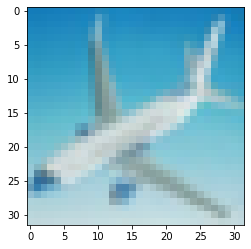

In [15]:
show_image(1701)

In [109]:
class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        #self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(32* 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.activ = nn.functional.relu
        self.dr2 = nn.Dropout()
        
          
    def forward(self, x):
        x = self.dr2(x)
        x = self.activ(self.fc1(x))
        x = self.dr2(x)
        x = self.activ(self.fc2(x))
        x = self.dr2(x)
        x = self.activ(self.fc3(x))
        x = self.dr2(x)
        x = self.fc4(x)
        
        return x

# Initialize settings for Neural Network

class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dr1 = nn.Dropout2d()
        self.dr2 = nn.Dropout()
        self.activ = nn.functional.relu
        
    def forward(self, x):
        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = x.view(-1,16*5*5)
        x = self.activ(self.fc1(x))
        x = self.dr2(x)
        x = self.activ(self.fc2(x))
        x = self.dr2(x)
        x = self.fc3(x)
        
        return x

## Function to calculate classification prediction accuracy

In [17]:
def accuracy(outputs, labels):
    prediction = outputs.max(1, keepdim=True)[1].squeeze()
    prediction_comp = torch.eq(prediction, labels)
    prediction_comp = prediction_comp.sum().numpy() / torch.numel(prediction)
    return prediction_comp * 100

In [110]:
neural_network = Neural_Network()

In [112]:
criterion = nn.CrossEntropyLoss()
number_of_epochs = 50
step_size = 0.005
momentum_parameter = 0.8
optimiser = optim.SGD(neural_network.parameters(), lr=step_size, momentum=momentum_parameter, weight_decay=0.0001)

running_loss = []
running_test_loss = []
running_training_accuracy = []
running_training_accuracy.append(0)
running_test_accuracy = []
running_test_accuracy.append(0)

print("Log -- Step size: {}, Momentum: {}, batch_size = {}".format(step_size,momentum_parameter,train_batch_size))
# loop for epochs
for k in range(number_of_epochs):
    epoch_loss = 0
    training_accuracy = 0
    
    for j, (images, labels) in enumerate(train_loader):
        optimiser.zero_grad()
        outputs = neural_network(images.view(-1, 3072))
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
        epoch_loss += loss.item()
        training_accuracy += accuracy(outputs, labels)
    
    running_loss.append(epoch_loss/len(train_loader))
    running_training_accuracy.append(training_accuracy/len(train_loader))
    
    test_images, test_labels = iter(test_loader).next()
    test_outputs = neural_network(test_images.view(-1,3072))
    test_loss = criterion(test_outputs, test_labels).item()
    running_test_loss.append(test_loss)
    test_accuracy = accuracy(test_outputs, test_labels)
    running_test_accuracy.append(test_accuracy)
    
    if k % 1 == 0:
        print("Epoch {a}/{b} -> Tr. Loss = {c:.2f}, Tst. Loss = {d:.2f}, Tr. Acc = {e}, Tst. Acc = {f}".format(a=k, b=number_of_epochs, c=running_loss[-1], d=running_test_loss[-1], e=running_training_accuracy[-1], f=running_test_accuracy[-1]))
    
    #if (len(running_test_loss) > 3) and (running_test_loss[-3] - running_test_loss[-1] < 0):
        #break
        
print("Final Epoch {} -> Loss = {}".format(k, running_loss[-1]))

Log -- Step size: 0.005, Momentum: 0.8, batch_size = 256
Epoch 0/50 -> Tr. Loss = 2.01, Tst. Loss = 1.98, Tr. Acc = 25.7633131377551, Tst. Acc = 26.61
Epoch 1/50 -> Tr. Loss = 1.95, Tst. Loss = 1.91, Tr. Acc = 28.997927295918366, Tst. Acc = 30.599999999999998
Epoch 2/50 -> Tr. Loss = 1.90, Tst. Loss = 1.88, Tr. Acc = 31.23923788265306, Tst. Acc = 31.34
Epoch 3/50 -> Tr. Loss = 1.87, Tst. Loss = 1.85, Tr. Acc = 32.68853635204081, Tst. Acc = 33.1
Epoch 4/50 -> Tr. Loss = 1.84, Tst. Loss = 1.82, Tr. Acc = 33.36375956632653, Tst. Acc = 34.74
Epoch 5/50 -> Tr. Loss = 1.81, Tst. Loss = 1.80, Tr. Acc = 34.779177295918366, Tst. Acc = 35.339999999999996
Epoch 6/50 -> Tr. Loss = 1.80, Tst. Loss = 1.78, Tr. Acc = 35.41772959183673, Tst. Acc = 36.059999999999995
Epoch 7/50 -> Tr. Loss = 1.78, Tst. Loss = 1.76, Tr. Acc = 36.134008290816325, Tst. Acc = 37.21
Epoch 8/50 -> Tr. Loss = 1.76, Tst. Loss = 1.75, Tr. Acc = 36.941964285714285, Tst. Acc = 36.730000000000004
Epoch 9/50 -> Tr. Loss = 1.75, Tst

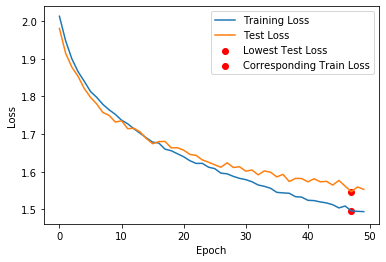

In [113]:
plt.plot(running_loss, label="Training Loss")
plt.plot(running_test_loss, label="Test Loss")
for i in range(len(running_test_loss)):
    if running_test_loss[i] == np.min(running_test_loss):
        lowest_index = i
plt.scatter(lowest_index, running_test_loss[lowest_index], label="Lowest Test Loss", c="r")
plt.scatter(lowest_index, running_loss[lowest_index], label="Corresponding Train Loss", c="r")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

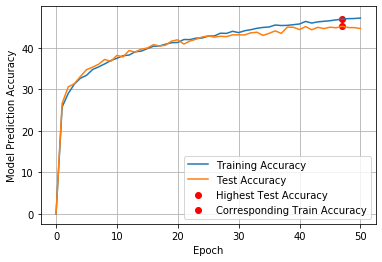

In [114]:
plt.plot(running_training_accuracy, label="Training Accuracy")
plt.plot(running_test_accuracy, label="Test Accuracy")
for i in range(len(running_test_accuracy)):
    if running_test_accuracy[i] == np.max(running_test_accuracy):
        highest_index = i
plt.scatter(highest_index, running_test_accuracy[highest_index], label="Highest Test Accuracy", c="r")
plt.scatter(highest_index, running_training_accuracy[highest_index], label="Corresponding Train Accuracy", c="r")
plt.legend()
plt.ylabel("Model Prediction Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.show()

In [35]:
epsilon = 0.07

In [21]:
fgsm_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('CIFAR10', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

Files already downloaded and verified


In [22]:
iter(fgsm_loader).next()[0].size()

torch.Size([1, 3, 32, 32])

In [23]:
def fgsm(images, epsilon, images_grad): 
    # need the orig image, 
    #loss - criterion = nn.CrossEntropyLoss(), 
    #gradient of the loss
    sign=images_grad.sign()
    print(sign.shape)
    new_image = images + epsilon * sign.to(dtype=torch.double) # ??
    return new_image

In [30]:
import torch.nn.functional as F

In [36]:
def testing_the_fsgm(neural_network, fgsm_loader, epsilon):
    
    correct = 0
    total = 0

    for j, (images, labels) in enumerate(fgsm_loader):


        images.requires_grad = True
        outputs = neural_network(images)
        prediction = outputs.max(1, keepdim=True)[1].squeeze()

        if prediction != labels:
            continue
        loss = F.nll_loss(outputs, labels)
        optimiser.zero_grad()
        loss.backward()
        images_grad = images.grad.data

        #perturbed_images = fgsm(images, epsilon, images_grad)

        peturbed_images=images+epsilon*images_grad.sign()
        outputs = neural_network(peturbed_images)
        final_pred = outputs.max(1, keepdim=True)[1].squeeze()


        total += 1
        correct += (final_pred == labels).sum()

    final_acc = correct/float(len(test_loader))
    #print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    print('Epsilon %.2f completed, Testing accuracy: %.2f %%' 
                   %(epsilon, final_acc))
            #print("Epoch {a}/{b} -> Tr. Loss = {c:.2f}, Tst. Loss = {d:.2f}, Tr. Acc = {e}, Tst. Acc = {f}"
            #      .format(a=k, b=number_of_epochs, c=running_loss[-1], d=running_test_loss[-1], 
            #              e=running_training_accuracy[-1], f=running_test_accuracy[-1]))
    
    return final_acc

In [37]:
test = testing_the_fsgm(neural_network, fgsm_loader, epsilon)

Epsilon 0.07 completed, Training accuracy: 614.00 %
